## 《合成孔径雷达成像——算法与实现》中6.4.4 大斜视角二次距离压缩的仿真实验（方式2）


In [21]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体 
plt.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题 

from numpy import pi,abs,max,min,argmax,argmin,ceil,exp,sqrt,real,imag,conj,sinc,sin,cos,tan,arctan,log10,angle,unwrap
from numpy import linspace,arange,zeros,ones,concatenate,convolve
from numpy.fft import fft,fftshift,ifft,ifftshift,fft2
from matplotlib.pyplot import figure,subplot,plot,axis,title,suptitle,xlabel,ylabel,text,arrow,tight_layout

In [22]:
## 参数设置
#  已知参数--》距离向参数
R_eta_c = 20e+3;                # 景中心斜距
Tr = 2.5e-6;                    # 发射脉冲时宽
Kr = 20e+12;                    # 距离向调频率
alpha_os_r = 1.2;               # 距离过采样率
Nrg = 320;                      # 距离线采样点数
#  计算参数--》距离向参数
Bw = abs(Kr)*Tr;                # 距离信号带宽
Fr = alpha_os_r*Bw;             # 距离向采样率
Nr = round(Fr*Tr);              # 距离采样点数(脉冲序列长度)
#  已知参数--》方位向参数
c = 3e+8;                       # 电磁传播速度
Vr = 150;                       # 等效雷达速度
Vs = Vr;                        # 卫星平台速度
Vg = Vr;                        # 波束扫描速度
f0 = 5.3e+9;                    # 雷达工作频率
Delta_f_dop = 80;               # 多普勒带宽
alpha_os_a = 1.25;              # 方位过采样率
Naz = 256;                      # 距离线数
theta_r_c = +21.9*pi/180;       # 波束斜视角
#  计算参数--》方位向参数
lambda0 = c/f0;                  # 雷达工作波长
t_eta_c = -R_eta_c*sin(theta_r_c)/Vr;
                                # 波束中心穿越时刻
f_eta_c = 2*Vr*sin(theta_r_c)/lambda0;
                                # 多普勒中心频率
La = 0.886*2*Vs*cos(theta_r_c)/Delta_f_dop;               
                                # 实际天线长度
Fa = alpha_os_a*Delta_f_dop;    # 方位向采样率
Ta = 0.886*lambda0*R_eta_c/(La*Vg*cos(theta_r_c));
                                # 目标照射时间
R0 = R_eta_c*cos(theta_r_c);    # 最短斜距
Ka = 2*Vr**2*cos(theta_r_c)**2/lambda0/R0;              
                                # 方位向调频率
theta_bw = 0.886*lambda0/La;     # 方位向3dB波束宽度
theta_syn = Vs/Vg*theta_bw;     # 合成角宽度
Ls = R_eta_c*theta_syn;         # 合成孔径长度
#  参数计算
rho_r = c/(2*Fr);               # 距离向分辨率
rho_a = La/2;                   # 距离向分辨率
Trg = Nrg/Fr;                   # 发射脉冲时宽
Taz = Naz/Fa;                   # 目标照射时间
d_t_tau = 1/Fr;                 # 距离采样时间间隔
d_t_eta = 1/Fa;                 # 方位采样时间间隔
d_f_tau = Fr/Nrg;               # 距离采样频率间隔    
d_f_eta = Fa/Naz;               # 方位采样频率间隔
## 目标设置
#  设置目标点相对于景中心之间的距离
A_r =   0; A_a =   0;                                   # A点位置
B_r = -50; B_a = -50;                                   # B点位置
C_r = -50; C_a = +50;                                   # C点位置
D_r = +50; D_a = C_a + (D_r-C_r)*tan(theta_r_c);        # D点位置
#  得到目标点相对于景中心的位置坐标
A_x = R0 + A_r; A_Y = A_a;                              # A点坐标
B_x = R0 + B_r; B_Y = B_a;                              # B点坐标
C_x = R0 + C_r; C_Y = C_a;                              # C点坐标
D_x = R0 + D_r; D_Y = D_a;                              # D点坐标
NPosition = np.array([[A_x,A_Y],
             [B_x,B_Y],
             [C_x,C_Y],
             [D_x,D_Y]      ])                          # 设置数组
# fprintf( 'A点坐标为[#+3.3f，#+3.3f]km\n', NPosition(1,1)/1e3, NPosition(1,2)/1e3 );
# fprintf( 'B点坐标为[#+3.3f，#+3.3f]km\n', NPosition(2,1)/1e3, NPosition(2,2)/1e3 );
# fprintf( 'C点坐标为[#+3.3f，#+3.3f]km\n', NPosition(3,1)/1e3, NPosition(3,2)/1e3 );
# fprintf( 'D点坐标为[#+3.3f，#+3.3f]km\n', NPosition(4,1)/1e3, NPosition(4,2)/1e3 );
#  得到目标点的波束中心穿越时刻
Ntarget = 4;
Tar_t_eta_c = zeros(Ntarget);
for i in range( Ntarget ):
    DeltaX = NPosition[i][1] - NPosition[i][0]*tan(theta_r_c);
    Tar_t_eta_c[i] = DeltaX/Vs;

#  得到目标点的绝对零多普勒时刻
Tar_t_eta_0 = zeros(Ntarget);
for i in range( Ntarget ):
    Tar_t_eta_0[i] = NPosition[i][1]/Vr;

## 变量设置
#  时间变量 以景中心的零多普勒时刻作为方位向零点
t_tau = arange(-Trg/2,Trg/2,d_t_tau) + 2*R_eta_c/c;   # 距离时间变量
t_eta = arange(-Taz/2,Taz/2,d_t_eta) + t_eta_c;       # 方位时间变量
#  长度变量
r_tau = (t_tau*c/2)*cos(theta_r_c);                     # 距离长度变量
#  频率变量 
f_tau = fftshift(arange(-Fr/2,Fr/2,d_f_tau));           # 距离频率变量
f_tau = f_tau - np.round((f_tau-0)/Fr)*Fr;                 # 距离频率变量(可观测频率)  
f_eta = fftshift(arange(-Fa/2,Fa/2,d_f_eta));           # 方位频率变量
f_eta = f_eta - np.round((f_eta-f_eta_c)/Fa)*Fa;           # 方位频率变量(可观测频率)
## 坐标设置     
#  以距离时间为X轴，方位时间为Y轴
t_tauX,t_etaY = np.meshgrid(t_tau,t_eta);                # 设置距离时域-方位时域二维网络坐标
#  以距离长度为X轴，方位频率为Y轴                                                                                                            
r_tauX,f_etaY = np.meshgrid(r_tau,f_eta);                # 设置距离时域-方位频域二维网络坐标
#  以距离频率为X轴，方位频率为Y轴                                                                                                            
f_tau_X,f_eta_Y = np.meshgrid(f_tau,f_eta);              # 设置频率时域-方位频域二维网络坐标

In [23]:
## 信号设置--》原始回波信号                                                                                                             
from tqdm import trange
bar = trange(Ntarget)
st_tt = zeros((Naz,Nrg),dtype="complex");
import time
for i in bar:
    #  计算目标点的瞬时斜距
    R_eta = sqrt( NPosition[i][0]**2 + Vr**2*(t_etaY-Tar_t_eta_0[i])**2 ); 
    #{
#     R_eta = NPosition[i][0] + Vr**2*t_etaY**2/(2*NPosition[i][0]);   
    #}
    #  后向散射系数幅度
    A0 = ones(4)*exp(+1j*0);   
    #  距离向包络
    wr = np.where(abs(t_tauX-2*R_eta/c) <= Tr/2,1,0);                               
    #  方位向包络
    wa = sinc(0.886*arctan(Vg*(t_etaY-Tar_t_eta_c[i])/NPosition[i][0])/theta_bw)**2;      
    #  接收信号叠加
    st_tt_tar = A0[i]*wr*wa*exp(-1j*4*pi*f0*R_eta/c)*exp(+1j*pi*Kr*(t_tauX-2*R_eta/c)**2); 

    #{
#     st_tt_tar = A0[i]*wr*wa*exp(-1j*4*pi*R0/lambda0)*exp(-1j*pi*Ka*t_eta_Y**2)*exp(+1j*pi*Kr*(t_tauX-2*R_eta/c)**2);
    #}                                                          
    st_tt = st_tt + st_tt_tar;  
    
    time.sleep(0.1);
    bar.set_description( ''+ str( np.round(i/Ntarget*100) ) )


75.0: 100%|██████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.78it/s]


In [24]:
# ##  绘图
# H = figure(figsize=(16,10));
# # set(H,'position',[100,100,600,600]);                    
# subplot(221),plt.pcolor( real(st_tt))             
# xlabel('距离时间(采样点)→'),ylabel('←方位时间(采样点)'),title('(a)实部')
# subplot(222),plt.pcolor( imag(st_tt))
# xlabel('距离时间(采样点)→'),ylabel('←方位时间(采样点)'),title('(b)虚部')
# subplot(223),plt.pcolor(  abs(st_tt)) 
# xlabel('距离时间(采样点)→'),ylabel('←方位时间(采样点)'),title('(c)幅度')
# subplot(224),plt.pcolor(angle(st_tt))
# xlabel('距离时间(采样点)→'),ylabel('←方位时间(采样点)'),title('(d)相位')
# plt.suptitle('图6.16 大斜视角情况下多点雷达原始仿真信号')


In [25]:
## 信号设置--》距离压缩
#  一次距离压缩
window = np.kaiser(Nrg,2.5);                              # 时域窗
Window = fftshift(window);                              # 频域窗
#  计算滤波器
Hrf = Window*exp(+1j*pi*f_tau_X**2/Kr);  
#  二次距离压缩
Drd0 = sqrt(1-lambda0**2*f_eta_c**2/(4*Vr**2));             # 距离多普勒域中的徙动因子
Ksrc = 2*Vr**2*f0**3*Drd0**3/(c*R0*f_eta_c**2);             # 距离补偿调频率
#  计算滤波器
Hsrcf = exp(-1j*pi*f_tau_X**2/Ksrc);  
#  匹配滤波
Sf_ft = fft(st_tt,Nrg,axis=1);
Srf_ft_33 = Sf_ft*Hrf*Hsrcf;
srt_tt_33 = ifft(Srf_ft_33,Nrg,axis=1);
## 信号设置--》方位向傅里叶变换
Saf_tf = fft(srt_tt_33,Naz,axis=0);

In [26]:
## 信号设置--》距离徙动校正
Drd = sqrt(1-lambda0**2*f_etaY**2/(4*Vr**2));              # 距离多普勒域中的徙动因子
RCM = r_tauX/Drd-r_tauX;                               # 需要校正的距离徙动量
RCM = R0 + RCM - R_eta_c;                               # 将距离徙动量转换到原图像坐标系中
offset = RCM/rho_r;                                     # 将距离徙动量转换为距离单元偏移量
#  计算插值系数表

x_tmp = np.tile(arange(-4,4,1),(16,1));                            # 插值长度                          
x_tmp = x_tmp + np.tile((arange(1,17,1)/16).reshape(16,1),(1,8));            # 量化位移
hx = sinc(x_tmp);                                       # 生成插值核
kwin = np.tile(np.kaiser(8,2.5),(16,1));                  # 加窗
hx = kwin*hx;
sm = np.sum(hx,axis=1)
hx = hx/np.tile(sm.reshape(16,1),(1,8));                       # 核的归一化

              
              
#  插值表校正

Srcmf_tf = zeros((Naz,Nrg),dtype='complex');
for a_tmp  in range(Naz):
    for r_tmp in range(Nrg):
        offset_ceil = ceil(offset[a_tmp,r_tmp]);
        offset_frac = round((offset_ceil - offset[a_tmp,r_tmp]) * 16);
        if offset_frac == 0:
            kk = int(ceil(np.mod(r_tmp+offset_ceil-0.1,Nrg)))
            Srcmf_tf[a_tmp,r_tmp] = Saf_tf[a_tmp,kk-1]; 
        else:
            kk = np.mod(arange(r_tmp+1+offset_ceil-4,r_tmp+1+offset_ceil+4,1)-0.1,Nrg)
            kk = (ceil(kk)).astype(int)
#             print( "kk:",kk)
            sdot = np.matmul(Saf_tf[a_tmp,kk-1].reshape(1,kk.size),hx[offset_frac-1,:].reshape(kk.size,1))
            Srcmf_tf[a_tmp,r_tmp] = sdot;
    
## 信号设置--》方位压缩
#  计算滤波器
Haf = exp(+1j*4*pi*f0*r_tauX*Drd/c);
Haf_offset = exp(-1j*2*pi*f_etaY*t_eta_c);
#  匹配滤波
Soutf_tf = Srcmf_tf*Haf*Haf_offset;
soutt_tt = ifft(Soutf_tf,Naz,axis=0);

Text(0.5, 0.98, '图6.17 方式3下二次距离压缩的精确实现')

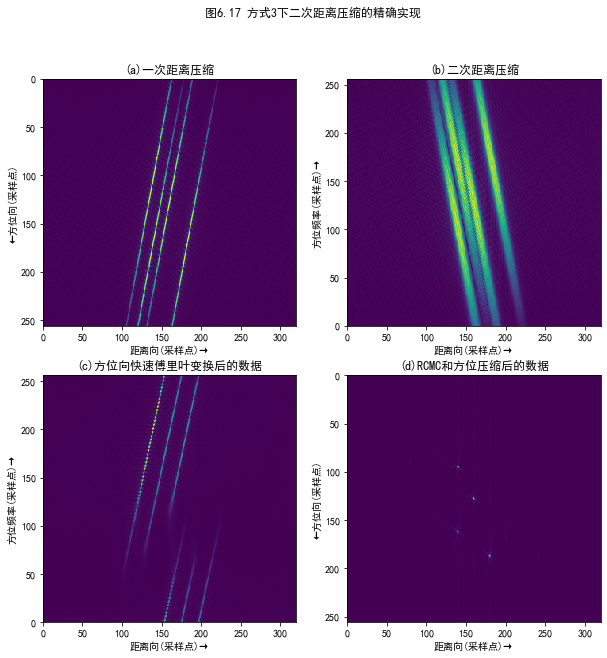

In [27]:
## 绘图
H = figure(figsize=(10,10));
subplot(221),plt.pcolor( abs(ifft(Sf_ft*Hrf,Nrg,axis=1)))
plt.gca().invert_yaxis()
xlabel('距离向(采样点)→'),ylabel('←方位向(采样点)'),title('(a)一次距离压缩')
subplot(222),plt.pcolor( abs(ifft(Sf_ft*Hrf*Hsrcf,Nrg,axis=1)))
xlabel('距离向(采样点)→'),ylabel('方位频率(采样点)→'),title('(b)二次距离压缩')
subplot(223),plt.pcolor( abs(Saf_tf))
xlabel('距离向(采样点)→'),ylabel('方位频率(采样点)→'),title('(c)方位向快速傅里叶变换后的数据')
subplot(224),plt.pcolor( abs(soutt_tt))
plt.gca().invert_yaxis()
xlabel('距离向(采样点)→'),ylabel('←方位向(采样点)'),title('(d)RCMC和方位压缩后的数据')
plt.suptitle('图6.17 方式3下二次距离压缩的精确实现')

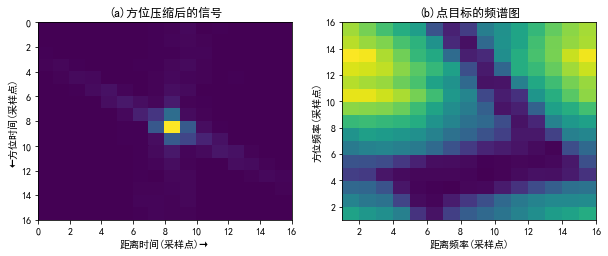

In [31]:
## 信号设置--》点目标分析

len = 16;
cut = arange(-len/2,len/2,1);
kk1 = round(Naz/2 +  NPosition[0,1]/Vr*Fa) + cut
kk2 = round(Nrg/2 +  2*(NPosition[0,0]-R0)/c*Fr) + cut
kk1 = kk1.astype(int)
kk2 = kk2.astype(int)
start_tt = soutt_tt[kk1,:];
start_tt = start_tt[:,kk2]
Start_ff = fft2(start_tt);
## 绘图
H2 = figure(figsize=(10,8)); 
subplot(221),plt.pcolor(abs(start_tt))#colormap gray
plt.gca().invert_yaxis()
xlabel('距离时间(采样点)→'),ylabel('←方位时间(采样点)'),title('(a)方位压缩后的信号')
subplot(222),plt.pcolor(abs(Start_ff))
axis([1,len,1,len])
xlabel('距离频率(采样点)');ylabel('方位频率(采样点)');title('(b)点目标的频谱图');


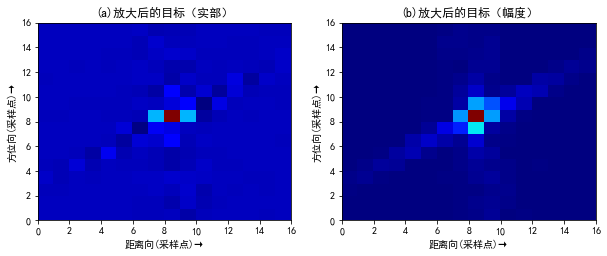

In [32]:
## 绘图
H2 = figure(figsize=(10,8)); 
subplot(221),plt.pcolor(real(start_tt),cmap='jet')
xlabel('距离向(采样点)→'),ylabel('方位向(采样点)→'),title('(a)放大后的目标（实部）')
subplot(222),plt.pcolor(abs(start_tt),cmap='jet')#s
xlabel('距离向(采样点)→');ylabel('方位向(采样点)→');title('(b)放大后的目标（幅度）');


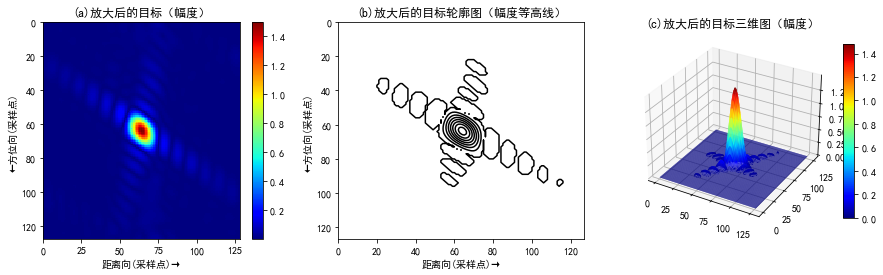

In [35]:
# 下面进行二维升采样
NN = 16
ac_test_1 = fft(start_tt, axis = 0);   # 方位向fft
ac_test_2 = fft(ac_test_1,axis = 1);   # 距离向fft
ac_test_buling_1 = zeros((8*NN,NN),dtype='complex');  # 中间变量
ac_test_buling = zeros((8*NN,8*NN),dtype='complex');
    # 下面先对每列补零，再对每行补零——注意：和上面的先行后列相比，这是有区别的。
for pp in range(NN):          # 在每行的最小值位置补零
    I = argmin(abs(ac_test_2[:,pp]));
    ac_test_buling_1[:I+1,pp] = ac_test_2[:I+1,pp];
    ac_test_buling_1[8*NN-(NN-I)+1:8*NN,pp] = ac_test_2[I+1:NN,pp];

for qq in range(8*NN):         # 在每列的最小值位置补零
    I = argmin(abs(ac_test_buling_1[qq,:]));
    ac_test_buling[qq,:I+1] = ac_test_buling_1[qq,:I+1];
    ac_test_buling[qq,8*NN-(NN-I)+1:8*NN] = ac_test_buling_1[qq,I+1:NN];

ac_test_1 = ifft(ac_test_buling,axis=1);
ac_test = ifft(ac_test_1,axis=0);         # 完成二维升采样。
# 作图
x = range(8*NN);y = range(8*NN)
X,Y = np.meshgrid(x,y)
Z = np.where(abs(ac_test) > 0.04, abs(ac_test), 0)
figure(figsize=(15,4));
subplot(131),plt.pcolor(abs(ac_test),cmap='jet');plt.colorbar()
xlabel('距离向(采样点)→'),ylabel('←方位向(采样点)'),title('(a)放大后的目标（幅度）')
plt.gca().invert_yaxis()
subplot(132),plt.contour(X,Y,Z,8,colors='k')
xlabel('距离向(采样点)→'),ylabel('←方位向(采样点)'),title('(b)放大后的目标轮廓图（幅度等高线）')
plt.gca().invert_yaxis()
sub = subplot(133,projection='3d')#3d表示三维图像
title('(c)放大后的目标三维图（幅度）')
surf=sub.plot_surface(X,Y,Z[X,Y],rstride=1, cstride=1, cmap='jet', edgecolor='none')
cb=plt.colorbar(surf,shrink=0.8,aspect=15)#添加颜色棒,shrink表示缩放,aspect表示宽



本文Python代码参照Matlab代码自：https://github.com/wanghs008/SAR-SignalProcessing